In [1]:
import warnings
warnings.filterwarnings('ignore')

# Computer vision libraries

* [`torchvision`](https://pytorch.org/vision/stable/index.html): base domain library for PyTorch computer vision
  * `torchvision.datasets`: datasets and data loading functionalities
  * `torchvision.models`: pretrained models
  * `torchvision.transforms`: common functions for image transformations
* `torchvision.utils.data.Dataset`: base class for datasets
* `torchvision.utils.data.DataLoader`: creates a Python iterable over a dataset

In [2]:
import torch
from torch import nn

torch.__version__

'2.1.0'

In [3]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

torchvision.__version__

'0.16.0'

# Setup device agnostic code

**Note**: Sometimes, depending on your data/hardware, you might find that your model trains faster on CPU than GPU. It could be that the overhead for copying data/model to and from the GPU outweighs the compute benefits offered by the GPU.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# 1. Fashion MNIST

The Fashion MNIST dataset is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

<image src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-computer-vision-input-and-output-shapes.png" width="833,3" height="500">

In [5]:
# setup training data
train_data = datasets.FashionMNIST(
  root="data",
  train=True,
  download=True,
  transform=ToTensor(),
  target_transform=None,
)

# setup test data
test_data = datasets.FashionMNIST(
  root="data",
  train=False,
  download=True,
  transform=ToTensor(),
  target_transform=None,
)

In [6]:
len(train_data), len(test_data)

(60000, 10000)

## 1.1. Check input and output shapes of data

In [7]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [9]:
# `image.shape` is in CxHxW format
# `label` is a scalar between 0 and 9
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

## 1.2. Visualizing the data

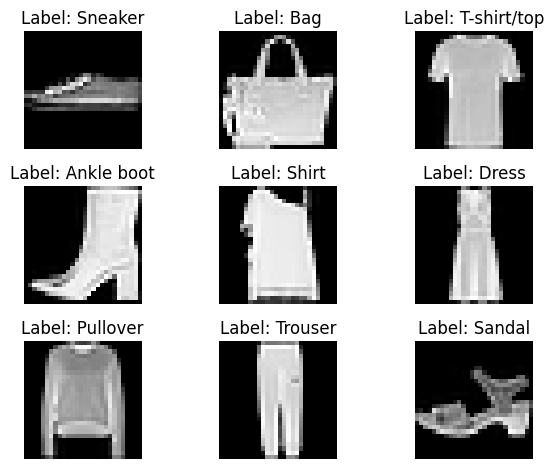

In [10]:
import matplotlib.pyplot as plt

for i in range(9):
    random_idx = torch.randint(low=0, high=len(train_data), size=[1]).item()

    plt.subplot(3, 3, i + 1)
    plt.imshow(train_data[random_idx][0].squeeze(), cmap="gray")
    plt.title(f"Label: {train_data.classes[train_data[random_idx][1]]}")
    plt.axis("off")

plt.tight_layout()

## 1.3. DataLoader and Batchfying

Right now, the data is in the form of PyTorch Datasets (see above). We want to convert them to PyTorch DataLoaders, which are Python iterables that return a batch of data (images and labels) at each iteration.

The processing of the data is performed in mini-batches. A mini-batch is a subset of the training set that is used to evaluate the model at each iteration. The size of the mini-batch is a hyperparameter that can be tuned. The size of the mini-batch is usually a power of 2 (e.g. 32, 64, 128, 256, etc.) and the most common value is 32.

Working with batches is more efficient than working with the whole dataset at each iteration. It also allows us to use the GPU to perform the computations and **gives the neural networks more chances to update its gradients per epoch**.

<image src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-batching-fashionmnist.png" width="833,3" height="500">

In [11]:
from torch.utils.data import DataLoader

# turn train dataset into Dataloader
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)

# turn test dataset into Dataloader
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x14735eeb0>,
 <torch.utils.data.dataloader.DataLoader at 0x1446d55e0>)

In [12]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [13]:
train_features_batch, train_label_batch = next(iter(train_dataloader))
train_features_batch.shape, train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

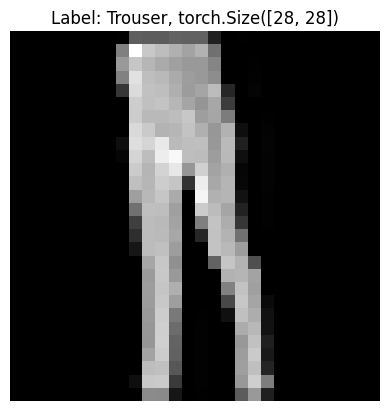

In [14]:
img = train_features_batch[0].squeeze()
label = train_label_batch[0]

plt.imshow(img, cmap="gray")
plt.title(f"Label: {train_data.classes[label]}, {img.shape}")
plt.axis("off");

# 2. Baseline model

## 2.1. Construct the model

The baseline model will use a linear layer to perform the classification. The input to the model will be a tensor of shape (N, 784) and the output will be a tensor of shape (N, 10). Since the linear layer cannot handle multi-dimensional data, we need to flatten the input tensor before passing it to the linear layer.

* `nn.Flatten`: flattens a tensor of shape (N, C, H, W) to a tensor of shape (N, C*H*W)

In [15]:
flatten_model = nn.Flatten()

X = train_features_batch[0]
output = flatten_model(X)

X.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [16]:
import torchmetrics
from torchmetrics import Accuracy, F1Score

# define model
model0 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=28*28, out_features=32),
    nn.Linear(in_features=32, out_features=10)
).to(device)

# pick loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model0.parameters(), lr=0.1)

# define eval metrics
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
f1 = F1Score(task="multiclass", num_classes=10).to(device)

In [17]:
# `untrained_logits`: the output of the model before any additional handling
with torch.inference_mode():
    untrained_logits = model0(train_features_batch[0].to(device))
untrained_logits

tensor([[ 0.2136, -0.0872, -0.3762, -0.3084, -0.0336, -0.0602, -0.2927,  0.0763,
          0.0783,  0.2019]])

In [18]:
# `untrained_preds_probs`: the probability of the logits after applying the softmax function
untrained_preds_probs = torch.softmax(untrained_logits, dim=1)
untrained_preds_probs[:5]

tensor([[0.1288, 0.0953, 0.0714, 0.0764, 0.1006, 0.0979, 0.0776, 0.1123, 0.1125,
         0.1273]])

In [19]:
untrained_preds = torch.argmax(untrained_preds_probs, dim=1)
untrained_preds, train_data.classes[untrained_preds]

(tensor([0]), 'T-shirt/top')

## 2.2. Fit the model to the data (train and eval loop)

One of the advantages of training the model on *batches* of data is that the optimizer will update the model's parameters once per batch rather than once per epoch. With every batch, the model is *hopefully* getting slightly better, because the `optimizer.step()` is in the batch loop rather than the epoch loop.

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train loss *per batch*
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*
4. Print out the average train and test loss per epoch
5. Time the training and testing steps

#### **Note about loss calculation**

In a multi-class classification problem like the one involving the FashionMNIST database, it's generally more appropriate to calculate the loss using the logits rather than the predicted probabilities (pred_probs).

>  Logits vs. Predicted Probabilities:
>  * Logits: these are the raw, unnormalized outputs of the last layer of a neural network before applying an activation function like the softmax. In PyTorch, functions like `nn.CrossEntropyLoss` expect logits as inputs. This loss function internally applies the softmax function to the logits and then computes the loss.
>  * Predicted Probabilities (pred_probs): these are the outputs after applying the softmax activation function to the logits, converting them into probabilities. If you use predicted probabilities as inputs for loss functions expecting logits, it can lead to incorrect training behavior and less effective learning.

>  Why Use Logits for Loss Calculation:
>  * Numerical Stability: directly using logits in loss functions like cross-entropy is numerically more stable. The softmax function can lead to very small probability values, which can cause numerical issues when computing the logarithm in cross-entropy.
>  * Efficiency: computing the loss directly from logits avoids the unnecessary computation of converting logits to probabilities and then back to log-probabilities in the loss function.
>  * Built-in Functionality: PyTorch's `nn.CrossEntropyLoss` combines softmax and cross-entropy loss in a single, more numerically stable operation.

In [20]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

def train_model(
        model: torch.nn.Sequential, 
        loss_fn: torch.nn.CrossEntropyLoss, 
        optim: torch.optim.SGD, 
        accuracy: torchmetrics.Metric, 
        f1: torchmetrics.Metric, 
        train_dataloader: DataLoader, 
        test_dataloader: DataLoader, 
        epochs: int = 5,
        model_name: str = "baseline-model"):
    """Performs training and evaluation of the model"""

    # training and testing metrics
    train_loss = train_acc = train_f1 = 0
    test_loss = test_acc = test_f1 = 0
    total_train_time = 0

    for epoch in tqdm(range(epochs)):
        start = timer()

        # training
        train_loss_per_batch = train_acc_per_batch = train_f1_per_batch = 0

        model0.train()
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)

            # forward pass
            logits = model(X)
            loss = loss_fn(logits, y)
            train_loss_per_batch += loss.item()

            # backward pass
            optim.zero_grad()
            loss.backward()

            # update parameters
            optim.step()

            # calculate accuracy and f1 score
            train_acc_per_batch += accuracy(logits.softmax(dim=1), y).item()
            train_f1_per_batch += f1(logits.softmax(dim=1), y).item()

        train_loss_per_batch /= len(train_dataloader)
        train_acc_per_batch /= len(train_dataloader)
        train_f1_per_batch /= len(train_dataloader)

        train_loss = train_loss_per_batch
        train_acc = train_acc_per_batch
        train_f1 = train_f1_per_batch

        # testing
        test_loss_per_batch = test_acc_per_batch = test_f1_per_batch = 0

        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)

                # forward pass
                logits = model(X)
                loss = loss_fn(logits, y)
                test_loss_per_batch += loss.item()

                # calculate accuracy and f1 score
                test_acc_per_batch += accuracy(logits.softmax(dim=1), y).item()
                test_f1_per_batch += f1(logits.softmax(dim=1), y).item()

        test_loss_per_batch /= len(test_dataloader)
        test_acc_per_batch /= len(test_dataloader)
        test_f1_per_batch /= len(test_dataloader)

        test_loss = test_loss_per_batch
        test_acc = test_acc_per_batch
        test_f1 = test_f1_per_batch

        end = timer()
        total_train_time += end - start
        print(f"Epoch: {epoch + 1}/{epochs}, "
                f"train_loss: {train_loss_per_batch:.4f}, test_loss: {test_loss_per_batch:.4f}, "
                f"train_acc: {train_acc_per_batch:.4f}, test_acc: {test_acc_per_batch:.4f}, "
                f"train_f1: {train_f1_per_batch:.4f}, test_f1: {test_f1_per_batch:.4f}, "
                f"time: {end - start:.2f}s")
        
    return {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "test_f1": test_f1,
        "total_train_time": total_train_time,
        "model_name": model_name
    }

In [21]:
# set seed for reproducibility
torch.manual_seed(42), torch.cuda.manual_seed(42)

# train model
model0_metrics = train_model(model0, loss_fn, optim, accuracy, f1, train_dataloader, test_dataloader, epochs=5, model_name="baseline-model")

 20%|██        | 1/5 [00:03<00:12,  3.15s/it]

Epoch: 1/5, train_loss: 0.5828, test_loss: 0.5068, train_acc: 0.7932, test_acc: 0.8227, train_f1: 0.7932, test_f1: 0.8227, time: 3.15s


 40%|████      | 2/5 [00:06<00:08,  2.98s/it]

Epoch: 2/5, train_loss: 0.4747, test_loss: 0.4832, train_acc: 0.8334, test_acc: 0.8297, train_f1: 0.8334, test_f1: 0.8297, time: 2.85s


 60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

Epoch: 3/5, train_loss: 0.4541, test_loss: 0.4776, train_acc: 0.8404, test_acc: 0.8344, train_f1: 0.8404, test_f1: 0.8344, time: 2.77s


 80%|████████  | 4/5 [00:11<00:02,  2.84s/it]

Epoch: 4/5, train_loss: 0.4419, test_loss: 0.4631, train_acc: 0.8444, test_acc: 0.8363, train_f1: 0.8444, test_f1: 0.8363, time: 2.78s


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]

Epoch: 5/5, train_loss: 0.4354, test_loss: 0.4683, train_acc: 0.8466, test_acc: 0.8329, train_f1: 0.8466, test_f1: 0.8329, time: 2.76s


# 3. Improved model with non-linearity

In [22]:
from torchmetrics import Accuracy, F1Score

# define model
model1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=28*28, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=10),
    nn.ReLU()
).to(device)

# pick loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model1.parameters(), lr=0.1)

# define eval metrics
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
f1 = F1Score(task="multiclass", num_classes=10).to(device)

In [23]:
# set seed for reproducibility
torch.manual_seed(42), torch.cuda.manual_seed(42)

# train model
model1_metrics = train_model(model1, loss_fn, optim, accuracy, f1, train_dataloader, test_dataloader, epochs=5, model_name="relu-model")

 20%|██        | 1/5 [00:02<00:11,  2.87s/it]

Epoch: 1/5, train_loss: 0.6574, test_loss: 0.4725, train_acc: 0.7658, test_acc: 0.8288, train_f1: 0.7658, test_f1: 0.8288, time: 2.87s


 40%|████      | 2/5 [00:05<00:08,  2.86s/it]

Epoch: 2/5, train_loss: 0.4286, test_loss: 0.4380, train_acc: 0.8421, test_acc: 0.8440, train_f1: 0.8421, test_f1: 0.8440, time: 2.86s


 60%|██████    | 3/5 [00:08<00:05,  2.85s/it]

Epoch: 3/5, train_loss: 0.3884, test_loss: 0.4056, train_acc: 0.8568, test_acc: 0.8560, train_f1: 0.8568, test_f1: 0.8560, time: 2.84s


 80%|████████  | 4/5 [00:11<00:02,  2.85s/it]

Epoch: 4/5, train_loss: 0.3664, test_loss: 0.3881, train_acc: 0.8652, test_acc: 0.8585, train_f1: 0.8652, test_f1: 0.8585, time: 2.84s


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]

Epoch: 5/5, train_loss: 0.3499, test_loss: 0.4115, train_acc: 0.8707, test_acc: 0.8512, train_f1: 0.8707, test_f1: 0.8512, time: 2.85s


# 4. Convolutional neural networks

The model architecture used here is based on TinyVGG, which is a simplified version of the VGG architecture. The VGG architecture was introduced in the paper [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556) by Karen Simonyan and Andrew Zisserman. The VGG architecture achieved very good performance on the ImageNet dataset and was one of the most popular and influential models in the 2014 ImageNet competition. Other popular architectures for image classification include AlexNet, ResNet, and Inception.

ConvNets are usually composed of blocks of convolutional layers, followed by a pooling layer, followed by another block of convolutional layers, followed by another pooling layer, and so on. The convolutional layers are responsible for extracting features from the input image, and the pooling layers are responsible for reducing the dimensionality of the extracted features. The last block of convolutional layers is usually followed by a few fully connected layers, which are responsible for combining the features and making the final predictions.

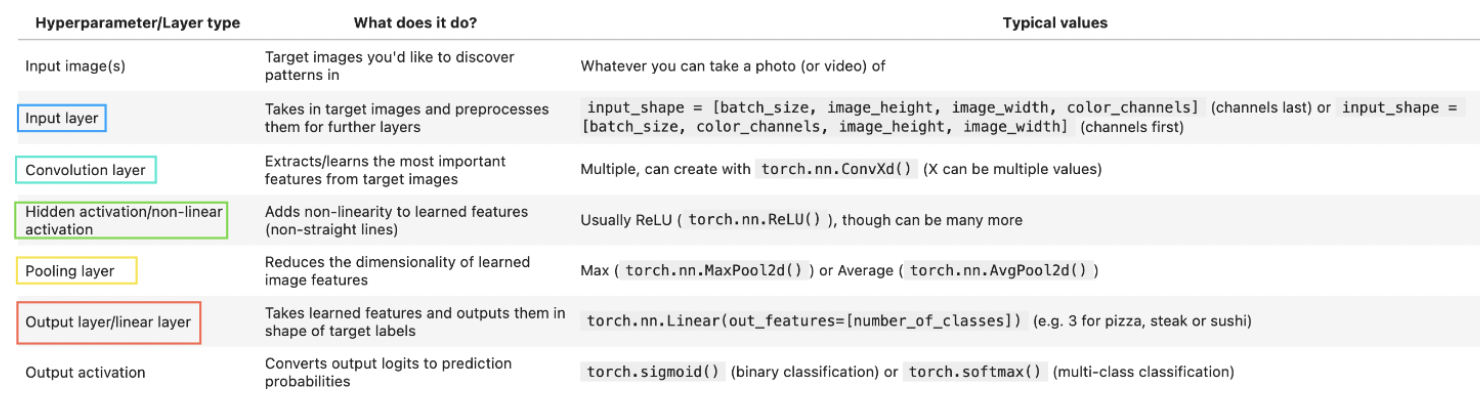

## 4.1. Understand convolutional and pooling layers

`kernel_size`: the size of the convolutional kernel. If the kernel size is (k, k), then the kernel will be a square kernel with k rows and k columns.

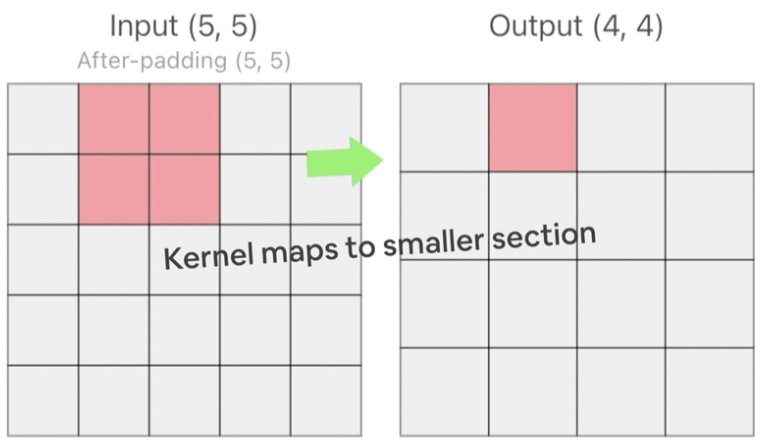

`stride`: the stride of the convolution. If the stride is s, then the kernel will move s pixels at a time as it slides over the image.

`padding`: the number of pixels to add to the input image when computing the convolution. If padding is p, then p rows and p columns of zeros will be added to the input image before computing the convolution. This ensures that the output of the convolution is the same size as the input. If padding is set to 0, then the size of the output will be smaller than the input.

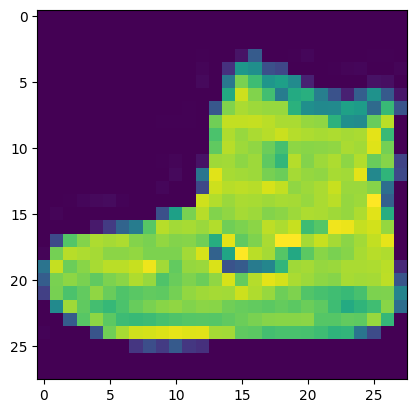

In [24]:
plt.imshow(image.permute(1, 2, 0).cpu().numpy());

In [25]:
# pass dummy images through convolutional layer
conv_layer1 = nn.Conv2d(in_channels=image.shape[0], out_channels=8, kernel_size=3, stride=1, padding=0)
conv_output1 = conv_layer1(image.unsqueeze(dim=0))
conv_output1.shape

torch.Size([1, 8, 26, 26])

In [26]:
conv_layer2 = nn.Conv2d(in_channels=image.shape[0], out_channels=8, kernel_size=5, stride=3, padding=0)
conv_output2 = conv_layer2(image.unsqueeze(dim=0))
conv_output2.shape

torch.Size([1, 8, 8, 8])

In [27]:
conv_layer3 = nn.Conv2d(in_channels=image.shape[0], out_channels=8, kernel_size=3, stride=3, padding=3)
conv_output3 = conv_layer3(image.unsqueeze(dim=0))
conv_output3.shape

torch.Size([1, 8, 11, 11])

In [28]:
max_pool_layer = nn.MaxPool2d(kernel_size=2)

max_pool_output1 = max_pool_layer(conv_output1)
max_pool_output2 = max_pool_layer(conv_output2)
max_pool_output3 = max_pool_layer(conv_output3)

max_pool_output1.shape, max_pool_output2.shape, max_pool_output3.shape

(torch.Size([1, 8, 13, 13]),
 torch.Size([1, 8, 4, 4]),
 torch.Size([1, 8, 5, 5]))

In [29]:
random_tensor = torch.randn(size=[1, 1, 2, 2])
random_tensor

tensor([[[[ 0.8178,  1.8935],
          [-0.0741,  0.1611]]]])

In [30]:
random_tensor_output = max_pool_layer(random_tensor)
random_tensor_output, random_tensor_output.shape

(tensor([[[[1.8935]]]]), torch.Size([1, 1, 1, 1]))

## 4.2. Build and train the model

In [31]:
class ConvNetModel(nn.Module):
    """
      A simple convolutional neural network model
      that repicates the Tiny VGG architecture

        Args:
            input_shape (int): the number of channels in the input
            hidden_units (int): the number of hidden units in the hidden layer
            output_shape (int): the number of classes in the output

        Components:
            conv_block_*: feature extractor block (convolutional block)
            classifier: classifier block for output prediction
    """
    def __init__(self, input_channels: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_alfa = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_beta = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_alfa(x)
        x = self.conv_block_beta(x)
        x = self.classifier(x)
        return x

In [32]:
# set seed for reproducibility
torch.manual_seed(42), torch.cuda.manual_seed(42)

model2 = ConvNetModel(input_channels=image.shape[0], hidden_units=32, output_shape=len(train_data.classes)).to(device)
model2

ConvNetModel(
  (conv_block_alfa): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_beta): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [33]:
# pick loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model2.parameters(), lr=0.1)

# define eval metrics
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
f1 = F1Score(task="multiclass", num_classes=10).to(device)

In [34]:
model2_metrics = train_model(model2, loss_fn, optim, accuracy, f1, train_dataloader, test_dataloader, model_name="convnet-model")

 20%|██        | 1/5 [01:12<04:49, 72.28s/it]

Epoch: 1/5, train_loss: 0.8169, test_loss: 0.3922, train_acc: 0.6843, test_acc: 0.8513, train_f1: 0.6843, test_f1: 0.8513, time: 72.28s


 40%|████      | 2/5 [02:25<03:38, 72.73s/it]

Epoch: 2/5, train_loss: 0.3486, test_loss: 0.3201, train_acc: 0.8711, test_acc: 0.8861, train_f1: 0.8711, test_f1: 0.8861, time: 73.05s


 60%|██████    | 3/5 [03:37<02:25, 72.52s/it]

Epoch: 3/5, train_loss: 0.2825, test_loss: 0.3088, train_acc: 0.8968, test_acc: 0.8875, train_f1: 0.8968, test_f1: 0.8875, time: 72.27s


 80%|████████  | 4/5 [04:50<01:12, 72.65s/it]

Epoch: 4/5, train_loss: 0.2486, test_loss: 0.2609, train_acc: 0.9090, test_acc: 0.9080, train_f1: 0.9090, test_f1: 0.9080, time: 72.86s


100%|██████████| 5/5 [06:05<00:00, 73.02s/it]

Epoch: 5/5, train_loss: 0.2272, test_loss: 0.2569, train_acc: 0.9171, test_acc: 0.9061, train_f1: 0.9171, test_f1: 0.9061, time: 74.64s


tensor([1]) Trouser tensor(1) Trouser


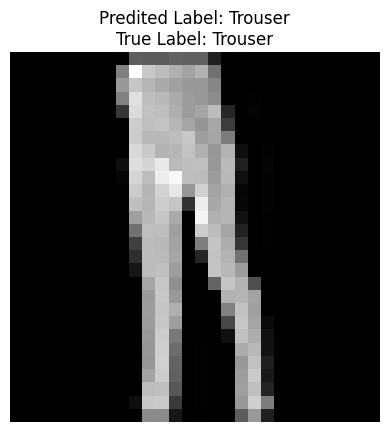

In [35]:
logit = model2(img.unsqueeze(dim=0).unsqueeze(dim=0).to(device))
pred_probs = torch.softmax(logit, dim=1)
pred = torch.argmax(pred_probs, dim=1)
print(pred, train_data.classes[pred], label, train_data.classes[label])

plt.imshow(img, cmap="gray")
plt.title(f"Predited Label: {train_data.classes[pred]}\nTrue Label: {train_data.classes[label]}")
plt.axis("off");

# 5. Comparing results of models

In [38]:
import pandas as pd

compare_results = pd.DataFrame([
    model0_metrics,
    model1_metrics,
    model2_metrics
]).set_index("model_name")
compare_results

,train_loss,train_acc,train_f1,test_loss,test_acc,test_f1,total_train_time
model_name,,,,,,,
baseline-model,0.435407,0.846600,0.846600,0.468327,0.832867,0.832867,14.314475
relu-model,0.349850,0.870683,0.870683,0.411525,0.851238,0.851238,14.251903
convnet-model,0.227213,0.917050,0.917050,0.256860,0.906050,0.906050,365.105136


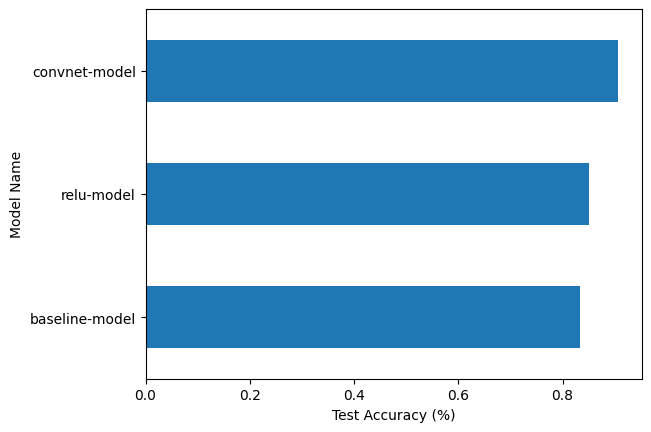

In [41]:
compare_results["test_acc"].plot(kind="barh")
plt.xlabel("Test Accuracy (%)")
plt.ylabel("Model Name");

# 6. Making and evaluating predictions with best model

In [42]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []

    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            logit = model(sample)
            pred_probs.append(torch.softmax(logit.squeeze(), dim=0).cpu())

    return torch.stack(pred_probs)

In [52]:
import random

random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape, test_labels[0]

(torch.Size([1, 28, 28]), 5)

In [56]:
pred_probs = make_predictions(model2, test_samples)
pred_classes = torch.argmax(pred_probs, dim=1)
pred_classes, test_labels

(tensor([5, 1, 7, 4, 3, 6, 4, 7, 1]), [5, 1, 7, 4, 3, 0, 4, 7, 1])

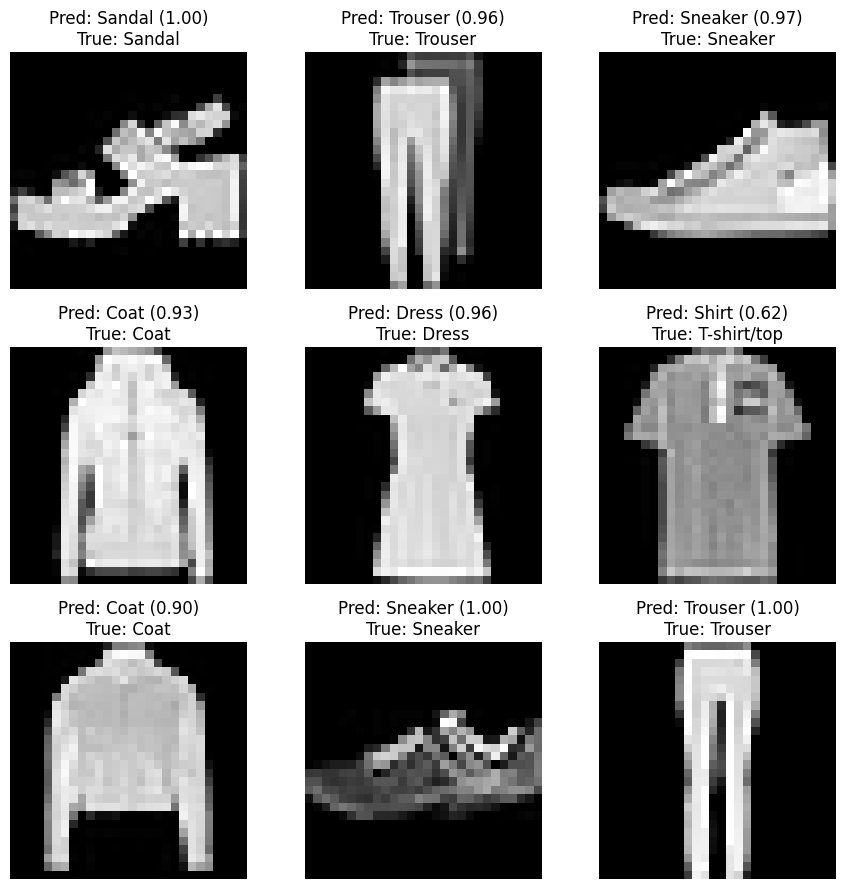

In [63]:
plt.figure(figsize=(9, 9))
nrows = ncols = 3

for i, sample in enumerate(test_samples):
    prediction = train_data.classes[pred_classes[i]]
    certainty = torch.max(pred_probs[i]).item()
    label = train_data.classes[test_labels[i]]

    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(sample.squeeze(), cmap="gray")
    plt.title(f"Pred: {prediction} ({certainty:.2f})\nTrue: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show;

## 6.1. Confusion matrix

In [72]:
y_preds = []

model2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)

        # forward pass
        logits = model2(X)
        y_preds.append(torch.softmax(logits.squeeze(), dim=1).argmax(dim=1).cpu())

y_preds = torch.cat(y_preds)
y_preds.shape

Making predictions...: 100%|██████████| 313/313 [00:03<00:00, 102.70it/s]


torch.Size([10000])

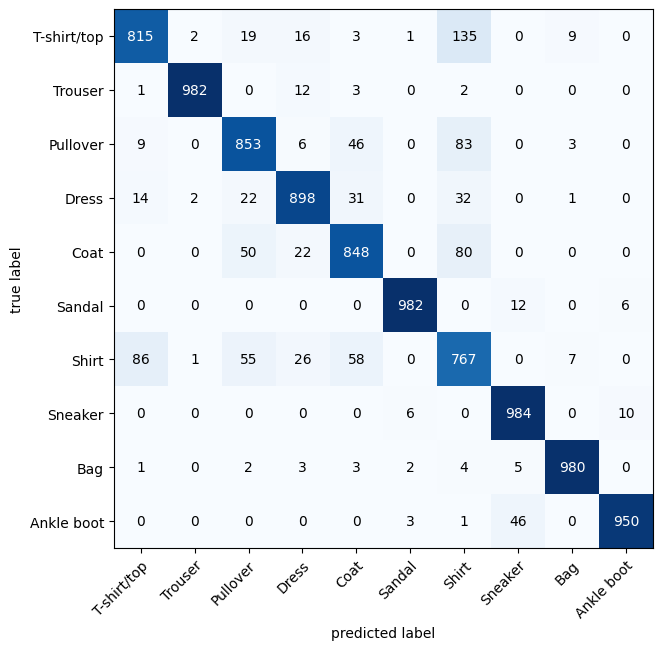

In [78]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

cm = ConfusionMatrix(num_classes=len(train_data.classes), task="multiclass")
cm_tensor = cm(y_preds, torch.tensor(test_data.targets))

fig, ax = plot_confusion_matrix(conf_mat=cm_tensor.numpy(), class_names=train_data.classes, figsize=(10, 7))

# References:

1. [Making Deep Learning Go Brrrr From First Principles](https://horace.io/brrr_intro.html)
2. [CNN Explainer](https://poloclub.github.io/cnn-explainer/)
3. [Ground truth notebook](https://www.learnpytorch.io/03_pytorch_computer_vision/)